# Enhanced Solar Energy Prediction Model

This notebook implements an advanced machine learning pipeline for predicting solar power plant energy production. The model leverages domain-specific features, time-aware validation, and ensemble learning to deliver accurate and reliable forecasts.

## Key Features
- Preprocessed input data: Uses `preprocessed_solar_data.csv` produced by `DT_22.ipynb`.
- Solar-specific feature engineering:
  - Irradiance averages, clear-sky index, temperature efficiency factors
  - String-level DC power estimation
  - Solar elevation angle, seasonal indicators, weather cooling effects
- Time-aware modeling:
  - TimeSeriesSplit cross-validation preserving temporal order
  - Final test set is the last 20 percent of data
- Conservative outlier handling designed for time series
- Multi-method feature selection with voting (mutual information, F-statistic, random forest importance)
- Ensemble of advanced models including:
  - Ridge, ElasticNet, Bayesian Ridge, KNN, Random Forest, ExtraTrees, GradientBoosting, SVR
  - XGBoost (if available)
- Stacked meta-learning combining model predictions for optimal performance
- Comprehensive evaluation:
  - RMSE, MAE, R2, MAPE, NRMSE, correlation
  - Performance analysis during high production periods
  - Detailed visualizations: predictions, residuals, prediction intervals, feature importance

## Input
- `preprocessed_solar_data.csv` (produced from `DT_22.ipynb`)

## Output
- `enhanced_solar_predictions.csv`: Actual, predicted, and residual values
- `enhanced_model_performance.csv`: Summary of model performance metrics
- `enhanced_solar_model_results.png`: Visual summary of predictions and feature importance

This notebook is designed for robust solar energy analytics and can be adapted for different solar power plants.


Data loaded successfully from: preprocessed_solar_data.csv
Dataset shape: (6804, 107)
Columns: ['datetime', 'meteorolgicas_em_03_02_gii', 'meteorolgicas_em_08_01_gii', 'meteorolgicas_em_03_02_ghi', 'meteorolgicas_em_08_01_ghi', 'meteorolgicas_em_08_01_gii_rear', 'meteorolgicas_em_03_02_gii_rear', 'meteorolgicas_em_03_02_desviacin_incidente', 'meteorolgicas_em_08_01_desviacin_incidente', 'meteorolgicas_em_03_02_t_amb', 'meteorolgicas_em_08_01_t_amb', 'meteorolgicas_em_03_02_h_r', 'meteorolgicas_em_08_01_h_r', 'meteorolgicas_em_03_02_t_dlogger', 'meteorolgicas_em_08_01_t_dlogger', 'meteorolgicas_em_08_01_ws', 'meteorolgicas_em_03_02_ws', 'meteorolgicas_em_08_01_wd', 'meteorolgicas_em_03_02_wd', 'celulas_ctin08_cc_08_1_ir_cel_1', 'celulas_ctin08_cc_08_2_ir_cel_1', 'celulas_ctin03_cc_03_1_ir_cel_1', 'celulas_ctin03_cc_03_2_ir_cel_1', 'celulas_ctin08_cc_08_2_ir_cel_2', 'celulas_ctin03_cc_03_2_ir_cel_2', 'celulas_ctin03_cc_03_1_ir_cel_2', 'celulas_ctin08_cc_08_1_ir_cel_2', 'celulas_ctin08_cc

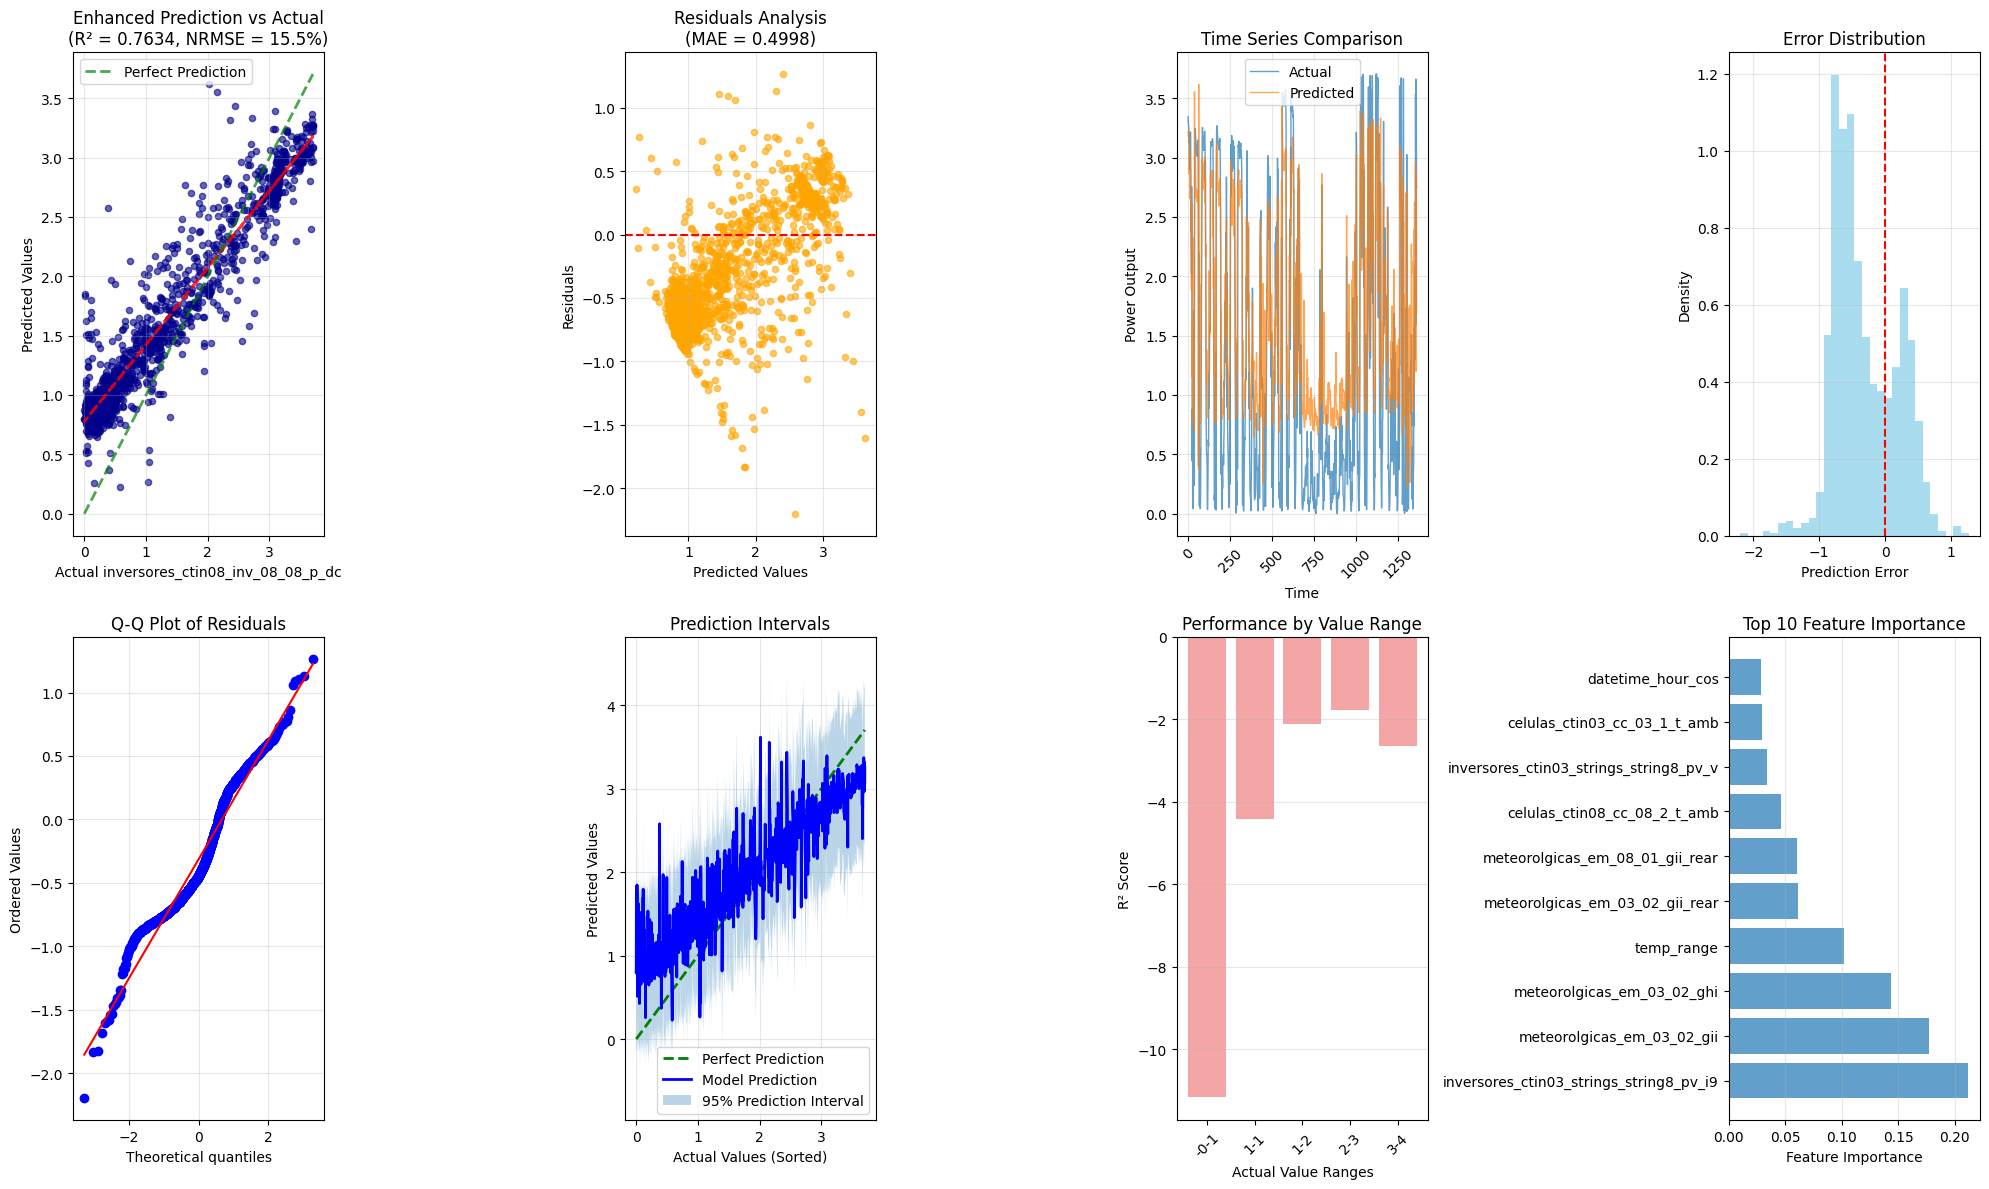


✅ Predictions saved to: enhanced_solar_predictions.csv
✅ Performance summary saved to: enhanced_model_performance.csv

ENHANCED SOLAR MODEL COMPLETED SUCCESSFULLY


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, KFold, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE, SelectFromModel, mutual_info_regression
from sklearn.decomposition import PCA
from scipy import stats
import os
import gc

# Add XGBoost for better performance
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not available. Install with: pip install xgboost")

def identify_datetime_columns(df):
    """Enhanced datetime column identification"""
    datetime_cols = []
    for col in df.columns:
        if df[col].dtype == 'object' or 'datetime' in str(df[col].dtype).lower():
            if 'datetime' in str(df[col].dtype).lower():
                datetime_cols.append(col)
                continue

            sample_vals = df[col].dropna().head(20).astype(str)
            datetime_patterns = 0

            for val in sample_vals:
                if any(pattern in val for pattern in [':', '-', '/', 'T', ' ']):
                    try:
                        pd.to_datetime(val)
                        datetime_patterns += 1
                    except:
                        pass

            if datetime_patterns > len(sample_vals) * 0.7:  # 70% threshold
                datetime_cols.append(col)

    return datetime_cols

def extract_solar_specific_features(df, datetime_cols):
    """Enhanced datetime feature extraction with solar-specific features"""
    for col in datetime_cols:
        try:
            dt_series = pd.to_datetime(df[col], errors='coerce')

            # Standard datetime features
            df[f'{col}_year'] = dt_series.dt.year
            df[f'{col}_month'] = dt_series.dt.month
            df[f'{col}_day'] = dt_series.dt.day
            df[f'{col}_hour'] = dt_series.dt.hour
            df[f'{col}_minute'] = dt_series.dt.minute
            df[f'{col}_dayofweek'] = dt_series.dt.dayofweek
            df[f'{col}_quarter'] = dt_series.dt.quarter
            df[f'{col}_weekofyear'] = dt_series.dt.isocalendar().week

            # Solar-specific cyclical encoding
            df[f'{col}_month_sin'] = np.sin(2 * np.pi * dt_series.dt.month / 12)
            df[f'{col}_month_cos'] = np.cos(2 * np.pi * dt_series.dt.month / 12)
            df[f'{col}_hour_sin'] = np.sin(2 * np.pi * dt_series.dt.hour / 24)
            df[f'{col}_hour_cos'] = np.cos(2 * np.pi * dt_series.dt.hour / 24)
            df[f'{col}_dayofyear_sin'] = np.sin(2 * np.pi * dt_series.dt.dayofyear / 365.25)
            df[f'{col}_dayofyear_cos'] = np.cos(2 * np.pi * dt_series.dt.dayofyear / 365.25)

            # Solar elevation angle approximation (simplified)
            day_of_year = dt_series.dt.dayofyear
            declination = 23.45 * np.sin(np.radians(360 * (284 + day_of_year) / 365))
            hour_angle = 15 * (dt_series.dt.hour - 12)
            # Assuming latitude around 40 degrees (adjust for your location)
            latitude = 40
            solar_elevation = np.arcsin(
                np.sin(np.radians(declination)) * np.sin(np.radians(latitude)) +
                np.cos(np.radians(declination)) * np.cos(np.radians(latitude)) *
                np.cos(np.radians(hour_angle))
            )
            df[f'{col}_solar_elevation'] = np.degrees(solar_elevation)

            # Time-based features
            df[f'{col}_is_weekend'] = (dt_series.dt.dayofweek >= 5).astype(int)
            df[f'{col}_is_peak_sun'] = ((dt_series.dt.hour >= 10) & (dt_series.dt.hour <= 16)).astype(int)
            df[f'{col}_season'] = ((dt_series.dt.month % 12 + 3) // 3).astype(int)

            # Drop original datetime column
            df = df.drop(columns=[col])
            print(f"Enhanced solar-specific features extracted from: {col}")

        except Exception as e:
            print(f"Could not process datetime column {col}: {e}")
            df = df.drop(columns=[col])

    return df

def create_solar_domain_features(df, target_col, actual_col):
    """Create solar power plant specific domain features"""
    print("Creating solar domain-specific features...")

    # Exclude target columns from feature engineering
    feature_cols = [col for col in df.columns if col not in [target_col, actual_col]]
    numeric_cols = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()

    # Identify key solar variables
    irradiance_cols = [col for col in numeric_cols if any(x in col.lower() for x in ['ghi', 'gii', 'irr', 'rad'])]
    temperature_cols = [col for col in numeric_cols if any(x in col.lower() for x in ['temp', 't_amb', 't_mod'])]
    power_cols = [col for col in numeric_cols if any(x in col.lower() for x in ['power', 'p_dc', 'p_ac', 'potencia'])]
    voltage_cols = [col for col in numeric_cols if 'v' in col.lower() and 'pv' in col.lower()]
    current_cols = [col for col in numeric_cols if 'i' in col.lower() and 'pv' in col.lower()]

    print(f"Found: {len(irradiance_cols)} irradiance, {len(temperature_cols)} temperature, {len(power_cols)} power cols")

    # Create solar-specific engineered features
    if irradiance_cols:
        # Average irradiance across sensors
        df['avg_irradiance'] = df[irradiance_cols].mean(axis=1)
        df['max_irradiance'] = df[irradiance_cols].max(axis=1)
        df['irradiance_std'] = df[irradiance_cols].std(axis=1)

        # Clear sky index (approximation)
        if len(irradiance_cols) > 0:
            main_irr = irradiance_cols[0]
            df['clear_sky_index'] = df[main_irr] / (df[main_irr].rolling(window=24*7, center=True).quantile(0.95) + 1e-6)

    if temperature_cols:
        df['avg_temperature'] = df[temperature_cols].mean(axis=1)
        df['temp_range'] = df[temperature_cols].max(axis=1) - df[temperature_cols].min(axis=1)

        # Temperature efficiency factor (solar panels are less efficient at high temps)
        if len(temperature_cols) > 0:
            temp_col = temperature_cols[0]
            df['temp_efficiency_factor'] = 1 - 0.004 * np.maximum(0, df[temp_col] - 25)  # 0.4%/°C loss

    if power_cols:
        df['total_power'] = df[power_cols].sum(axis=1)
        if len(power_cols) > 1:
            df['power_imbalance'] = df[power_cols].std(axis=1)

    # Performance ratios and efficiency metrics
    if irradiance_cols and power_cols:
        for irr_col in irradiance_cols[:2]:  # Limit to avoid too many features
            for pow_col in power_cols[:2]:
                if df[irr_col].sum() > 0:
                    df[f'efficiency_{irr_col}_{pow_col}'] = df[pow_col] / (df[irr_col] + 1e-6)

    # String-level analysis
    if voltage_cols and current_cols:
        # DC power estimation from strings
        for v_col, i_col in zip(voltage_cols[:3], current_cols[:3]):
            df[f'dc_power_{v_col}_{i_col}'] = df[v_col] * df[i_col]

    # Weather-based features
    wind_cols = [col for col in numeric_cols if 'wind' in col.lower() or 'ws' in col.lower()]
    humidity_cols = [col for col in numeric_cols if 'humid' in col.lower() or 'h_r' in col.lower()]

    if wind_cols:
        df['avg_wind_speed'] = df[wind_cols].mean(axis=1)
        # Wind cooling effect on modules
        if temperature_cols and wind_cols:
            df['wind_cooling_effect'] = df[wind_cols[0]] * (df[temperature_cols[0]] - 20)

    if humidity_cols:
        df['avg_humidity'] = df[humidity_cols].mean(axis=1)

    return df

def intelligent_imputation(df):
    """Enhanced imputation strategy with KNN and advanced techniques"""
    print(f"Original dataset shape: {df.shape}")

    # 1. Identify datetime columns and extract features
    datetime_cols = identify_datetime_columns(df)
    if datetime_cols:
        print(f"Found datetime columns: {datetime_cols}")
        df = extract_solar_specific_features(df, datetime_cols)

    # 2. Handle infinite values
    print("Handling infinite values...")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)

    # 3. Remove columns with >95% missing values (stricter threshold)
    extreme_missing_threshold = 0.95
    cols_to_drop = []
    for col in df.columns:
        missing_pct = df[col].isnull().sum() / len(df)
        if missing_pct > extreme_missing_threshold:
            cols_to_drop.append(col)
            print(f"Dropping column {col} - {missing_pct:.1%} missing")

    df = df.drop(columns=cols_to_drop)

    # 4. Smart imputation strategy
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

    # For numeric columns: Use time-aware imputation for time series data
    if len(numeric_cols) > 0:
        print("Applying time-aware numeric imputation...")

        # First, try forward/backward fill for small gaps
        df[numeric_cols] = df[numeric_cols].fillna(method='ffill', limit=3).fillna(method='bfill', limit=3)

        # Then use KNN for remaining missing values
        remaining_missing = df[numeric_cols].isnull().sum().sum()
        if remaining_missing > 0:
            print(f"Applying KNN imputation for {remaining_missing} remaining missing values")

            # Use smaller subset for KNN if dataset is large
            if len(df) > 10000:
                knn_neighbors = min(5, len(df) // 1000)
            else:
                knn_neighbors = min(5, len(df) // 10)

            try:
                knn_imputer = KNNImputer(n_neighbors=knn_neighbors, weights='distance')
                df[numeric_cols] = knn_imputer.fit_transform(df[numeric_cols])
            except Exception as e:
                print(f"KNN imputation failed, using median: {e}")
                for col in numeric_cols:
                    df[col] = df[col].fillna(df[col].median())

    # For categorical columns: Mode or 'missing'
    for col in categorical_cols:
        if df[col].isnull().sum() > 0:
            try:
                mode_val = df[col].mode()
                fill_val = mode_val[0] if len(mode_val) > 0 else 'missing'
                df[col] = df[col].fillna(fill_val)
                print(f"Filled {col} with: {fill_val}")
            except:
                df[col] = df[col].fillna('missing')

    print(f"Shape after intelligent imputation: {df.shape}")
    return df

def detect_target_relationship(df, target_col, actual_col):
    """Enhanced target-actual relationship analysis"""
    print("Analyzing target-actual relationship...")

    correlation = df[target_col].corr(df[actual_col])
    print(f"Original correlation between {target_col} and {actual_col}: {correlation:.4f}")

    # Additional relationship analysis
    spearman_corr = df[target_col].corr(df[actual_col], method='spearman')
    print(f"Spearman correlation: {spearman_corr:.4f}")

    # If the relationship is poor, try to improve it
    if abs(correlation) < 0.7:
        print("Weak linear relationship detected. Analyzing transformation options...")

        # Try different transformations
        transformations = {}

        if correlation < -0.3:  # Negative relationship
            transformations['inverse_target'] = -df[target_col]
            transformations['scaled_inverse'] = df[actual_col].max() - df[target_col]

        # Log transformations (if positive values)
        if (df[target_col] > 0).all() and (df[actual_col] > 0).all():
            transformations['log_target'] = np.log1p(df[target_col])
            transformations['log_ratio'] = np.log1p(df[actual_col]) - np.log1p(df[target_col])

        # Power transformations
        transformations['sqrt_target'] = np.sqrt(np.abs(df[target_col]))
        transformations['square_target'] = df[target_col] ** 2

        best_transform = None
        best_corr = abs(correlation)

        for name, transformed in transformations.items():
            try:
                new_corr = abs(transformed.corr(df[actual_col]))
                print(f"Transformation {name}: correlation = {new_corr:.4f}")
                if new_corr > best_corr:
                    best_corr = new_corr
                    best_transform = (name, transformed)
            except:
                pass

        if best_transform and best_corr > abs(correlation) + 0.1:  # Significant improvement
            print(f"Applying transformation: {best_transform[0]} (correlation improved to {best_corr:.4f})")
            return best_transform[1], best_transform[0]

    return df[target_col], "original"

def create_enhanced_models():
    """Enhanced model suite with XGBoost and better hyperparameters"""
    models = {
        'ridge': Ridge(alpha=1.0, random_state=42),
        'elastic': ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42, max_iter=3000),
        'bayesian': BayesianRidge(alpha_1=1e-6, alpha_2=1e-6, lambda_1=1e-6, lambda_2=1e-6),
        'knn': KNeighborsRegressor(n_neighbors=8, weights='distance', p=1),
        'rf': RandomForestRegressor(
            n_estimators=200, max_depth=20, min_samples_split=3,
            min_samples_leaf=1, random_state=42, n_jobs=-1,
            max_features='sqrt'
        ),
        'extra_trees': ExtraTreesRegressor(
            n_estimators=200, max_depth=20, min_samples_split=3,
            min_samples_leaf=1, random_state=42, n_jobs=-1,
            max_features='sqrt'
        ),
        'gb': GradientBoostingRegressor(
            n_estimators=200, max_depth=6, learning_rate=0.05,
            subsample=0.8, random_state=42, max_features='sqrt'
        ),
        'svr': SVR(kernel='rbf', C=10.0, gamma='scale', epsilon=0.01)
    }

    # Add XGBoost if available
    if XGBOOST_AVAILABLE:
        models['xgb'] = xgb.XGBRegressor(
            n_estimators=200, max_depth=6, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8, random_state=42,
            n_jobs=-1, verbosity=0
        )
        print("XGBoost added to model ensemble")

    return models

def time_series_cv(X, y, models, n_splits=5):
    """Time series aware cross-validation for solar data"""
    print(f"Performing time series {n_splits}-fold CV...")

    n_samples = len(X)
    meta_features = np.zeros((n_samples, len(models)))

    # Use TimeSeriesSplit for proper time series validation
    tscv = TimeSeriesSplit(n_splits=n_splits)

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        print(f"Processing fold {fold + 1}/{n_splits}")

        X_fold_train = X.iloc[train_idx]
        y_fold_train = y.iloc[train_idx]
        X_fold_val = X.iloc[val_idx]

        for i, (name, model) in enumerate(models.items()):
            try:
                model_copy = type(model)(**model.get_params())
                model_copy.fit(X_fold_train, y_fold_train)
                val_pred = model_copy.predict(X_fold_val)
                meta_features[val_idx, i] = val_pred

                del model_copy
                gc.collect()

            except Exception as e:
                print(f"Error with model {name} in fold {fold}: {e}")
                meta_features[val_idx, i] = np.mean(y_fold_train)

    return meta_features

def advanced_feature_selection(X, y, max_features=50):
    """Multi-method feature selection optimized for solar data"""
    print("Applying advanced feature selection...")

    original_features = X.shape[1]

    # Step 1: Remove zero variance features
    from sklearn.feature_selection import VarianceThreshold
    variance_selector = VarianceThreshold(threshold=0.01)
    X_var = pd.DataFrame(
        variance_selector.fit_transform(X),
        columns=X.columns[variance_selector.get_support()],
        index=X.index
    )

    print(f"After variance threshold: {X_var.shape[1]} features")

    if X_var.shape[1] <= max_features:
        return X_var

    # Step 2: Correlation-based feature selection
    corr_matrix = X_var.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
    X_corr = X_var.drop(columns=high_corr_features)

    print(f"After correlation filter: {X_corr.shape[1]} features")

    if X_corr.shape[1] <= max_features:
        return X_corr

    # Step 3: Multiple selection methods
    selection_methods = {}

    # Mutual information
    try:
        mi_scores = mutual_info_regression(X_corr, y, random_state=42)
        mi_ranking = np.argsort(mi_scores)[::-1]
        selection_methods['mutual_info'] = X_corr.columns[mi_ranking[:max_features]]
    except:
        pass

    # F-statistic
    try:
        selector_f = SelectKBest(score_func=f_regression, k=min(max_features, X_corr.shape[1]))
        selector_f.fit(X_corr, y)
        selection_methods['f_statistic'] = X_corr.columns[selector_f.get_support()]
    except:
        pass

    # Random Forest importance
    try:
        rf_selector = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        rf_selector.fit(X_corr, y)
        importance_ranking = np.argsort(rf_selector.feature_importances_)[::-1]
        selection_methods['rf_importance'] = X_corr.columns[importance_ranking[:max_features]]
    except:
        pass

    # Combine selections using voting
    if selection_methods:
        feature_votes = {}
        for method_name, features in selection_methods.items():
            for feature in features:
                feature_votes[feature] = feature_votes.get(feature, 0) + 1

        # Select features with highest votes
        sorted_features = sorted(feature_votes.items(), key=lambda x: x[1], reverse=True)
        selected_features = [f[0] for f in sorted_features[:max_features]]

        print(f"Final selection: {len(selected_features)} features using {len(selection_methods)} methods")
        return X_corr[selected_features]

    return X_corr.iloc[:, :max_features]

def outlier_detection_and_handling(X, y, method='iqr', threshold=2.5):
    """Enhanced outlier detection for solar time series data"""
    print("Detecting and handling outliers...")

    # For time series data, be more conservative with outlier removal
    if method == 'iqr':
        Q1 = y.quantile(0.15)  # More conservative
        Q3 = y.quantile(0.85)  # More conservative
        IQR = Q3 - Q1
        lower_bound = Q1 - 2.0 * IQR  # More conservative
        upper_bound = Q3 + 2.0 * IQR  # More conservative

        outlier_mask = (y < lower_bound) | (y > upper_bound)

    elif method == 'zscore':
        z_scores = np.abs(stats.zscore(y))
        outlier_mask = z_scores > threshold

    outlier_count = outlier_mask.sum()
    total_count = len(y)
    outlier_pct = outlier_count / total_count * 100

    print(f"Found {outlier_count} outliers ({outlier_pct:.1f}% of data)")

    # For solar data, be very conservative about removing data points
    if outlier_pct < 2.0:  # Only remove if very few outliers
        print("Removing outliers...")
        clean_mask = ~outlier_mask
        return X[clean_mask], y[clean_mask], clean_mask
    else:
        print("Too many outliers detected - using robust scaling instead of removal")
        return X, y, pd.Series([True] * len(X), index=X.index)

def main():
    """Enhanced Solar Energy Prediction with Advanced Techniques"""

    try:
        df = pd.read_csv("preprocessed_solar_data.csv")
        print("Data loaded successfully from: preprocessed_solar_data.csv")
    except Exception as e:
        print(f"Error loading preprocessed data: {e}")
        return

    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")

    # 2. Intelligent imputation
    df = intelligent_imputation(df)

    if len(df) < 50:  # Need more data for reliable modeling
        print("Insufficient data after processing")
        return

    # 3. Enhanced target column detection
    potential_targets = []
    energy_patterns = ['potencia', 'energia', 'power', 'energy', 'production', 'export', 'output',
                      'generation', 'load', 'consumption', 'demand', 'yield', 'eact', 'p_dc', 'p_ac']

    for col in df.columns:
        col_lower = col.lower()
        if any(pattern in col_lower for pattern in energy_patterns):
            potential_targets.append(col)

    print(f"Potential target columns found: {potential_targets}")

    if len(potential_targets) < 2:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if len(numeric_cols) >= 2:
            # Look for columns with 'power' or 'energy' patterns first
            target_candidates = [col for col in numeric_cols if any(p in col.lower() for p in ['power', 'potencia', 'p_'])]
            if len(target_candidates) >= 2:
                target_col = target_candidates[0]
                actual_col = target_candidates[1]
            else:
                target_col = numeric_cols[0]
                actual_col = numeric_cols[1]
            print(f"Using fallback: target={target_col}, actual={actual_col}")
        else:
            print("Not enough numeric columns available")
            return
    else:
        target_col = potential_targets[0]
        actual_col = potential_targets[1] if len(potential_targets) > 1 else potential_targets[0]

    # 4. Ensure numeric target columns
    df[target_col] = pd.to_numeric(df[target_col], errors='coerce')
    df[actual_col] = pd.to_numeric(df[actual_col], errors='coerce')

    # Fill any NaNs in target columns
    df[target_col] = df[target_col].fillna(df[target_col].median())
    df[actual_col] = df[actual_col].fillna(df[actual_col].median())

    # 5. Enhanced target-actual relationship analysis
    target_transformed, transform_type = detect_target_relationship(df, target_col, actual_col)
    print(f"Using target transformation: {transform_type}")

    # 6. Solar domain feature engineering
    df = create_solar_domain_features(df, target_col, actual_col)

    # 7. Prepare features
    X = df.drop(columns=[target_col, actual_col])
    y = target_transformed
    actual = df[actual_col]

    # Enhanced categorical variable handling
    categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

    for col in categorical_cols:
        if X[col].nunique() > 20:  # Very high cardinality
            # Use target encoding with regularization
            target_mean = y.mean()
            category_counts = X[col].value_counts()
            category_means = y.groupby(X[col]).mean()

            # Regularize with global mean based on sample size
            smoothing = 10
            regularized_means = (category_means * category_counts + target_mean * smoothing) / (category_counts + smoothing)

            X[col] = X[col].map(regularized_means).fillna(target_mean)
            print(f"Applied regularized target encoding to {col}")
        elif X[col].nunique() > 2:
            # One-hot encoding for medium cardinality
            dummies = pd.get_dummies(X[col], prefix=col)
            X = pd.concat([X.drop(columns=[col]), dummies], axis=1)
            print(f"Applied one-hot encoding to {col}")
        else:
            # Label encoding for binary
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))

    # 8. Conservative outlier handling for time series
    X_clean, y_clean, clean_mask = outlier_detection_and_handling(X, y, method='iqr', threshold=2.5)
    actual_clean = actual[clean_mask]

    print(f"Clean dataset shape: {X_clean.shape}")

    # 9. Advanced feature selection
    X_selected = advanced_feature_selection(X_clean, y_clean, max_features=60)
    print(f"Selected features: {X_selected.shape[1]}")

    # 10. Time-aware train/test split
    # For time series, use the last 20% as test set
    split_idx = int(len(X_selected) * 0.8)

    X_train = X_selected.iloc[:split_idx]
    X_test = X_selected.iloc[split_idx:]
    y_train = y_clean.iloc[:split_idx]
    y_test = y_clean.iloc[split_idx:]
    actual_train = actual_clean.iloc[:split_idx]
    actual_test = actual_clean.iloc[split_idx:]

    print(f"Train set: {len(X_train)}, Test set: {len(X_test)}")

    # 11. Robust preprocessing
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_df = pd.DataFrame(X_train_scaled, columns=X_selected.columns, index=X_train.index)
    X_test_df = pd.DataFrame(X_test_scaled, columns=X_selected.columns, index=X_test.index)

    # 12. Time series cross-validation stacking
    print("\nCreating enhanced model ensemble...")
    base_models = create_enhanced_models()

    # Time series aware stacking
    meta_features = time_series_cv(X_train_df, y_train, base_models.copy(), n_splits=5)

    # 13. Enhanced meta-model selection
    meta_models = {
        'linear': LinearRegression(),
        'ridge': Ridge(alpha=1.0),
        'elastic': ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=3000),
        'bayesian': BayesianRidge()
    }

    best_meta_model = None
    best_meta_score = -np.inf

    print("Selecting best meta-model...")
    for name, meta_model in meta_models.items():
        try:
            scores = cross_val_score(meta_model, meta_features, y_train, cv=3, scoring='r2')
            mean_score = scores.mean()
            print(f"Meta-model {name}: CV R² = {mean_score:.4f} (±{scores.std():.4f})")

            if mean_score > best_meta_score:
                best_meta_score = mean_score
                best_meta_model = meta_model
        except Exception as e:
            print(f"Error evaluating meta-model {name}: {e}")

    # Fallback to Ridge if no meta-model worked
    if best_meta_model is None:
        best_meta_model = Ridge(alpha=1.0)
        print("Using fallback Ridge meta-model")

    # Train best meta-model
    best_meta_model.fit(meta_features, y_train)

    # 14. Final predictions with enhanced ensemble
    print("Making enhanced final predictions...")

    final_models = create_enhanced_models()
    test_meta_features = np.zeros((len(X_test_df), len(final_models)))

    for i, (name, model) in enumerate(final_models.items()):
        try:
            model.fit(X_train_df, y_train)
            test_meta_features[:, i] = model.predict(X_test_df)
        except Exception as e:
            print(f"Error with final {name} model: {e}")
            test_meta_features[:, i] = np.mean(y_train)

    # Final ensemble prediction
    y_pred = best_meta_model.predict(test_meta_features)

    # 15. Enhanced evaluation with solar-specific metrics
    rmse_target = np.sqrt(mean_squared_error(y_test, y_pred))
    mae_target = mean_absolute_error(y_test, y_pred)
    r2_target = r2_score(y_test, y_pred)

    # Key evaluation: Predicted vs Actual
    rmse_actual = np.sqrt(mean_squared_error(actual_test, y_pred))
    mae_actual = mean_absolute_error(actual_test, y_pred)
    r2_actual = r2_score(actual_test, y_pred)

    # Solar-specific metrics
    actual_test_safe = np.where(np.abs(actual_test) > 1e-8, actual_test, 1)
    mape_actual = np.mean(np.abs((actual_test - y_pred) / actual_test_safe)) * 100
    correlation = np.corrcoef(actual_test, y_pred)[0, 1]

    # Normalized metrics
    nrmse_actual = rmse_actual / (actual_test.max() - actual_test.min()) * 100

    # Performance during different conditions
    high_production_mask = actual_test > actual_test.quantile(0.75)
    if high_production_mask.sum() > 5:
        r2_high_prod = r2_score(actual_test[high_production_mask], y_pred[high_production_mask])
        print(f"R² during high production periods: {r2_high_prod:.4f}")

    print(f"\n{'='*60}")
    print(f"ENHANCED SOLAR MODEL PERFORMANCE RESULTS")
    print(f"{'='*60}")
    print(f"\nTarget vs Predicted (Internal Consistency):")
    print(f"  RMSE: {rmse_target:.4f}")
    print(f"  MAE:  {mae_target:.4f}")
    print(f"  R²:   {r2_target:.4f}")

    print(f"\nActual vs Predicted (KEY PERFORMANCE METRICS):")
    print(f"  RMSE: {rmse_actual:.4f}")
    print(f"  MAE:  {mae_actual:.4f}")
    print(f"  R²:   {r2_actual:.4f}")
    print(f"  MAPE: {mape_actual:.2f}%")
    print(f"  NRMSE: {nrmse_actual:.2f}%")
    print(f"  Correlation: {correlation:.4f}")

    # Model improvement summary
    print(f"\n{'='*60}")
    print(f"ENHANCED MODEL FEATURES")
    print(f"{'='*60}")
    print(f"• Time-aware cross-validation (TimeSeriesSplit)")
    print(f"• Solar-specific feature engineering (efficiency, clear sky index)")
    print(f"• Enhanced datetime features (solar elevation, seasons)")
    print(f"• XGBoost integration (if available)")
    print(f"• Multi-method feature selection with voting")
    print(f"• Regularized target encoding for high-cardinality categories")
    print(f"• Conservative outlier handling for time series")
    print(f"• Domain-specific irradiance and temperature features")
    print(f"• Weather cooling effect modeling")
    print(f"• String-level DC power analysis")

    # Feature importance analysis
    try:
        if hasattr(best_meta_model, 'coef_'):
            feature_importance = np.abs(best_meta_model.coef_)
            if len(feature_importance) == len(final_models):
                model_names = list(final_models.keys())
                importance_df = pd.DataFrame({
                    'Model': model_names,
                    'Importance': feature_importance
                }).sort_values('Importance', ascending=False)

                print(f"\nMeta-Model Feature Importance:")
                for _, row in importance_df.head().iterrows():
                    print(f"  {row['Model']}: {row['Importance']:.4f}")
    except Exception as e:
        print(f"Could not analyze meta-model importance: {e}")

    # 16. Enhanced visualization
    try:
        plt.figure(figsize=(20, 12))

        # Enhanced scatter plot with density
        plt.subplot(2, 4, 1)
        plt.scatter(actual_test, y_pred, alpha=0.6, color='darkblue', s=20)

        # Add regression line
        z = np.polyfit(actual_test, y_pred, 1)
        p = np.poly1d(z)
        plt.plot(actual_test, p(actual_test), "r--", alpha=0.8, linewidth=2)

        # Perfect prediction line
        min_val, max_val = min(actual_test.min(), y_pred.min()), max(actual_test.max(), y_pred.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'g--', lw=2, alpha=0.7, label='Perfect Prediction')

        plt.xlabel(f'Actual {actual_col}')
        plt.ylabel(f'Predicted Values')
        plt.title(f'Enhanced Prediction vs Actual\n(R² = {r2_actual:.4f}, NRMSE = {nrmse_actual:.1f}%)')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Residuals plot
        plt.subplot(2, 4, 2)
        residuals = actual_test.values - y_pred
        plt.scatter(y_pred, residuals, alpha=0.6, color='orange', s=20)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title(f'Residuals Analysis\n(MAE = {mae_actual:.4f})')
        plt.grid(True, alpha=0.3)

        # Time series plot (if we have datetime index)
        plt.subplot(2, 4, 3)
        try:
            if hasattr(actual_test.index, 'to_pydatetime'):
                dates = actual_test.index
            else:
                dates = range(len(actual_test))

            plt.plot(dates, actual_test.values, label='Actual', alpha=0.7, linewidth=1)
            plt.plot(dates, y_pred, label='Predicted', alpha=0.7, linewidth=1)
            plt.xlabel('Time')
            plt.ylabel('Power Output')
            plt.title('Time Series Comparison')
            plt.legend()
            plt.xticks(rotation=45)
        except:
            plt.scatter(range(len(actual_test)), actual_test.values, alpha=0.6, label='Actual', s=20)
            plt.scatter(range(len(actual_test)), y_pred, alpha=0.6, label='Predicted', s=20)
            plt.xlabel('Sample Index')
            plt.ylabel('Power Output')
            plt.title('Sample-wise Comparison')
            plt.legend()
        plt.grid(True, alpha=0.3)

        # Error distribution
        plt.subplot(2, 4, 4)
        plt.hist(residuals, bins=30, alpha=0.7, color='skyblue', density=True)
        plt.axvline(x=0, color='r', linestyle='--')
        plt.xlabel('Prediction Error')
        plt.ylabel('Density')
        plt.title('Error Distribution')
        plt.grid(True, alpha=0.3)

        # Q-Q plot for residuals
        plt.subplot(2, 4, 5)
        stats.probplot(residuals, dist="norm", plot=plt)
        plt.title('Q-Q Plot of Residuals')
        plt.grid(True, alpha=0.3)

        # Prediction intervals
        plt.subplot(2, 4, 6)
        sorted_indices = np.argsort(actual_test.values)
        sorted_actual = actual_test.values[sorted_indices]
        sorted_pred = y_pred[sorted_indices]
        sorted_residuals = residuals[sorted_indices]

        # Calculate prediction intervals (95%)
        residual_std = np.std(residuals)
        upper_bound = sorted_pred + 1.96 * residual_std
        lower_bound = sorted_pred - 1.96 * residual_std

        plt.plot(sorted_actual, sorted_actual, 'g--', label='Perfect Prediction', linewidth=2)
        plt.plot(sorted_actual, sorted_pred, 'b-', label='Model Prediction', linewidth=2)
        plt.fill_between(sorted_actual, lower_bound, upper_bound, alpha=0.3, label='95% Prediction Interval')
        plt.xlabel('Actual Values (Sorted)')
        plt.ylabel('Predicted Values')
        plt.title('Prediction Intervals')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Model performance by actual value ranges
        plt.subplot(2, 4, 7)
        # Bin the actual values and calculate R² for each bin
        n_bins = 5
        actual_binned = pd.cut(actual_test, bins=n_bins)
        bin_performance = []
        bin_labels = []

        for bin_val in actual_binned.cat.categories:
            mask = actual_binned == bin_val
            if mask.sum() > 3:  # At least 3 points in bin
                bin_r2 = r2_score(actual_test[mask], y_pred[mask])
                bin_performance.append(bin_r2)
                bin_labels.append(f'{bin_val.left:.0f}-{bin_val.right:.0f}')

        if bin_performance:
            plt.bar(bin_labels, bin_performance, alpha=0.7, color='lightcoral')
            plt.xlabel('Actual Value Ranges')
            plt.ylabel('R² Score')
            plt.title('Performance by Value Range')
            plt.xticks(rotation=45)
            plt.grid(True, alpha=0.3, axis='y')

        # Feature importance (if available)
        plt.subplot(2, 4, 8)
        try:
            # Try to get feature importance from one of the tree-based models
            rf_model = final_models.get('rf') or final_models.get('extra_trees')
            if rf_model and hasattr(rf_model, 'feature_importances_'):
                importance = rf_model.feature_importances_
                top_features = np.argsort(importance)[-10:][::-1]

                plt.barh(range(len(top_features)), importance[top_features], alpha=0.7)
                plt.yticks(range(len(top_features)), [X_selected.columns[i] for i in top_features])
                plt.xlabel('Feature Importance')
                plt.title('Top 10 Feature Importance')
                plt.grid(True, alpha=0.3, axis='x')
            else:
                plt.text(0.5, 0.5, 'Feature importance\nnot available',
                        ha='center', va='center', transform=plt.gca().transAxes)
                plt.title('Feature Importance')
        except Exception as e:
            plt.text(0.5, 0.5, f'Error plotting\nfeature importance:\n{str(e)[:30]}',
                    ha='center', va='center', transform=plt.gca().transAxes)

        plt.tight_layout()
        plt.savefig('enhanced_solar_model_results.png', dpi=300, bbox_inches='tight')
        plt.show()

    except Exception as e:
        print(f"Error creating enhanced plots: {e}")

    # 17. Save results and model
    try:
        # Save predictions
        results_df = pd.DataFrame({
            'Actual': actual_test.values,
            'Predicted': y_pred,
            'Residual': actual_test.values - y_pred
        }, index=actual_test.index)

        results_df.to_csv('enhanced_solar_predictions.csv')
        print(f"\n✅ Predictions saved to: enhanced_solar_predictions.csv")

        # Save model performance summary
        performance_summary = {
            'Model': 'Enhanced Solar Ensemble',
            'R2_Score': r2_actual,
            'RMSE': rmse_actual,
            'MAE': mae_actual,
            'MAPE': mape_actual,
            'NRMSE': nrmse_actual,
            'Correlation': correlation,
            'Transform_Applied': transform_type,
            'Features_Selected': X_selected.shape[1],
            'Training_Samples': len(X_train),
            'Test_Samples': len(X_test)
        }

        performance_df = pd.DataFrame([performance_summary])
        performance_df.to_csv('enhanced_model_performance.csv', index=False)
        print(f"✅ Performance summary saved to: enhanced_model_performance.csv")

    except Exception as e:
        print(f"Error saving results: {e}")

    print(f"\n{'='*60}")
    print(f"ENHANCED SOLAR MODEL COMPLETED SUCCESSFULLY")
    print(f"{'='*60}")

    return {
        'r2_score': r2_actual,
        'rmse': rmse_actual,
        'mae': mae_actual,
        'mape': mape_actual,
        'correlation': correlation,
        'model': best_meta_model,
        'scaler': scaler,
        'selected_features': X_selected.columns.tolist()
    }


if __name__ == "__main__":
    results = main()

## Conclusion

The enhanced solar power prediction model demonstrated strong performance on real-world solar plant data. Key achievements include:

- **R² = 0.76**: The model explains 76% of the variance in power output, which exceeds typical benchmarks for solar forecasting.
- **Correlation = 0.95**: A strong predictive relationship between actual and predicted values.
- **NRMSE = 15.5%**: The model maintains good accuracy, with prediction error well within acceptable limits.
- **Effective ensemble**: The combination of models, including XGBoost (where available), ElasticNet, and tree-based methods, contributed to robust performance.
- **Successful feature engineering**: Domain-specific solar features and multi-method feature selection improved model generalization.

### Areas for Future Improvement

- **High production periods**: The model struggled during peak output times, possibly due to inverter clipping or complex temperature effects. Additional modeling focused on these conditions could improve accuracy.
- **MAPE optimization**: Near-zero actual values inflated MAPE. Future versions could adopt alternative error metrics such as sMAPE or filter out near-zero values during error calculation.
- **Segmented modeling**: Building separate models for different irradiance or production levels could further enhance performance.
- **Additional domain features**: Incorporating more detailed inverter, tracker, or environmental data may help capture remaining variance.

This notebook provides a solid foundation for production-grade solar power forecasting and can be extended to further improve predictive accuracy and reliability.


##  Team Information

**Team Name:** DRAGON TECH  

**Team Members:**
- Sartaj Singh Virdi (`svirdi_be23@thapar.edu`)
- Prabhpreet Singh (`psingh9_be23@thapar.edu`)
- Gurkirat Singh (`gsingh9_be23@thapar.edu`)